### Introduction

This is an example how to gather information on a twitter user and store the data in a database. This data is later used for analysis. The search is very simple: Start with the one user, get the last x tweets and store them. Extract and store the location information and find all twitter users mentioned in the tweets. Sort the users by how often they are mentioned and put the top x% in the database. Now start over with these users. The network grows very fast and we have to limit the search depth. In this example I collect 1000 tweets, keep the top 2% of twitter users and search to a depth of 3 (max 2 edges away from the source node). 

### Define central user
To start, let's define a twitter user whose network we want to explore. Let's choose 'testuser', a non-exisiting one. Please substitute this string with your username of interest. 

In [1]:
source_node_name = 'testuser'

### Create and connect to database

Let's set-up the database storing the information and connect to it. The database is defined in src/db_tables.py and will be filled during the information gathering phase and cotain tables for i) USER, ii) MESSAGE, iii) LOCATION and iv) CONNECTION. All information will be stored in data/'source_node_name'.db and can be accessed using sqlite. 

In [2]:
from src.db_tables import Base, User, Connection, Message, Location, create_sqlite_db
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# Create the database.
db_path = 'sqlite:///data/' + source_node_name + '.db'
create_sqlite_db(db_path)
# Set-up a connection.
engine = create_engine(db_path)
Base.metadata.bind = engine 
DBSession = sessionmaker(bind=engine)
session = DBSession()

### Connect to twitter API

Now let's set-up the twitter connection. To be able to connect to the twitter api, get up your twitter login credentials (explained for example here: https://goo.gl/SXIslG) and add them to src/twitter_auth.py. 

In [6]:
from src.users import Twitter_user
from src.twitter_auth import Twitter_auth

user = Twitter_user(source_node_name, Twitter_auth().authenticate()) 

### Collect data

Now you are ready to collect the information. Be careful to limit your search! The twitter API allows only limited queries per hour. 

In [8]:
from src.network_search import Network_search

message_count = 200          # Number of tweets to collect from each user visited (The twitter API limits this to 200). 
dump = False                 # Do you want to store the tweets for each user in a separate JSON file? 
fraction_connections = 0.1   # How many of the top users (weighted by how often mentioned) should be added to the database 
max_depth = 2                # Stop the search when the users are more than max_depth edges away.
verbose = 1                  # Verbosity of search 

search = Network_search(user_object=user, db_session=session)
search.run(message_count=message_count, dump=dump, fraction_connections=fraction_connections, max_depth=max_depth, verbose=verbose) 

Network search started.
Iterating through 1 users at current depth 0
Iterating through 20 users at current depth 1
Iterating through 297 users at current depth 2
Collected 58694 tweets from 4063 users in 1551.876793s


### Summary data gathering

With a few line of code we can easily ~50k tweets from 4k users around the user of interest. The information is stored in an sqlite database which can be either queried directly (sqlite3 testuser.db) or within python. 

### Summary statistics

We can demonstrate this with some simple queries: Let's collect summary statistics for each user and plot the distribution over all users.

array([[<matplotlib.axes.AxesSubplot object at 0x10f41fc90>,
        <matplotlib.axes.AxesSubplot object at 0x10fd39390>]], dtype=object)

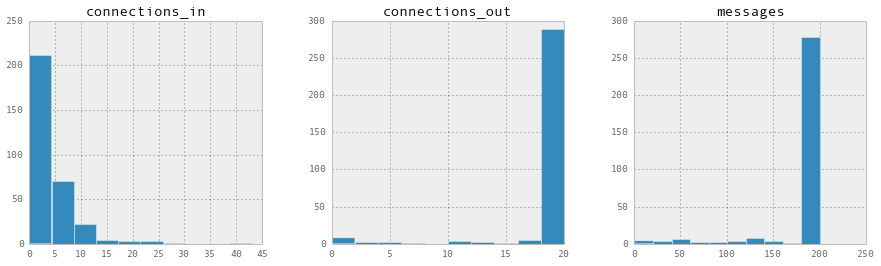

In [55]:
%matplotlib inline
import pandas as pd 
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier

rows_list = [] 
for user in session.query(User).all(): 
    message_count = len(session.query(Message).filter(Message.user_name == str(user.name)).all())
    connection_out = len(session.query(Connection).filter(Connection.user_1_name == str(user.name)).all())
    connection_in = len(session.query(Connection).filter(Connection.user_2_name == str(user.name)).all())
    rows_list.append({'messages':message_count, 'connections_in':connection_in, 'connections_out':connection_out})
df = pd.DataFrame(rows_list)
df = df[['messages', 'connections_out', 'connections_in']]   # reorder columns
df = df[df['messages'] != 0]                                 # Keep only users with messages
pd.DataFrame.hist(df, figsize=[15, 4], layout=[1, 3]);       # Plot histogram

We can clearly see that almost all users have at least 200 messages and that in these messages mention at least 20 other twitter users. The distribution of incoming connections is more interesting: The vast majority of users are mentioned very few, where a small fraction is mentioned often.

### Network analysis

Can we get a better understanding for the network architecture? To this end we can generate a graph from all the connections. Here the nodes represent user and the edges connections. Here I'm using networkx (https://networkx.github.io/) to do the analysis, but there a variety of graph analysis packages out there. So let's visualize the graph. 

In [ ]:
%load_ext autoreload
%autoreload 2
from src.network_graph import NetworkGraph
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 12))
ng = NetworkGraph(session)              # Create a NetworkGraph object and connect it to the database 
ng.build()                              # Build the graph by reading all the connection and parse them as edges  
ng.draw(node_size=2, edge_width=0.5);   # Draw a simple graph